In [2]:
# import the nexessary libraries
from PIL import Image
from os import listdir
from keras.models import load_model
import numpy as np
from numpy import asarray,expand_dims
from keras_facenet import FaceNet
import pickle
import cv2
import os
import re
from mtcnn import MTCNN
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix,classification_report

In [8]:
# same as training 
HaarCascade = cv2.CascadeClassifier(cv2.samples.findFile(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml'))
model_face = FaceNet()
mtcnn = MTCNN()

In [9]:
# load the database from data_processed.pkl file
myfile = open("data_processed.pkl", "rb")
database = pickle.load(myfile)
myfile.close()

In [10]:
# add the list of manually labelled images (102 images)
names=['abhinav','unknown','shree','abhinav','ishan','bhumit','unknown','unknown','vaibhav','samarth'
,'rohit','rohit','pushpendra','ram','unknown','chavi','karanpal','unknown','karanpal','hima'
,'chavi','lakshay','aakash','unknown','lakshay','sajal','aakash','manav','sukrit','ishan'
,'unknown','ishan','ishan','bhumit','aakash','samarth','ishan','bhumit','unknown','vedant'
,'aakash','abhinav','aakash','aakash','abhinav','aakash','shree','bhumit','abhinav','aayan'
,'vaibhav','bhumit','kundan','kundan','kundan','aayan','vedant','aayan','aayan','sukrit'
,'aayan','karanpal','karanpal','sajal','sajal','sukrit','sukrit','sajal','karanpal','sukrit'
,'karanpal','chavi','vaibhav','vaibhav','vaibhav','lakshay','vedant','vaibhav','vedant','aayan'
,'vaibhav','sukrit','samarth','karanpal','chavi','chavi','chavi','manav','lakshay','lakshay'
,'vedant','aakash','ishan','manav','aayan','vaibhav','pushpendra','rohit','ram','chavi'
,'karanpal','hima']


In [11]:
# Convert the list to a set to remove duplicates
unique_entries = list(set(names))

# Now, 'unique_entries' will contain the distinct entries
print(unique_entries)

['samarth', 'manav', 'aayan', 'kundan', 'vaibhav', 'karanpal', 'sukrit', 'abhinav', 'hima', 'chavi', 'vedant', 'pushpendra', 'bhumit', 'unknown', 'shree', 'ram', 'lakshay', 'aakash', 'sajal', 'rohit', 'ishan']


In [12]:
folder = 'testing_images/'
file_list = os.listdir(folder)

# intialise empty list for storing predicted names
predicted=[]

# Define a custom sorting function to extract the numeric part of the filename
def extract_number(filename):
    match = re.search(r'(\d+)', filename)
    if match:
        return int(match.group())
    return float('inf')  # If there are no numbers in the filename, treat it as infinity

# iterate through the sorted files as as training 
file_list_new = sorted(file_list, key=extract_number)
for filename in file_list_new:
    path = os.path.join(folder, filename)
    gbr1 = cv2.imread(folder + filename)
    
    harr = HaarCascade.detectMultiScale(gbr1,1.1,4)
    faces_mtcnn = mtcnn.detect_faces(gbr1)
    if len(harr)>0:
        x1, y1, width, height = harr[0] 
    elif len(faces_mtcnn) > 0:
        x1, y1, width, height = faces_mtcnn[0]['box']
    else:
        x1, y1, width, height = 1, 1, 10, 10
    
    x1, y1 = abs(x1), abs(y1)
    x2, y2 = x1 + width, y1 + height

    gbr = cv2.cvtColor(gbr1, cv2.COLOR_BGR2RGB)
    gbr = Image.fromarray(gbr)  # Convert from OpenCV to PIL
    gbr_array = asarray(gbr)

    face = gbr_array[y1:y2, x1:x2]

    face = Image.fromarray(face)
    face = face.resize((160, 160))
    face = asarray(face)
    
    # compute the embeddings similar to the training
    face = expand_dims(face, axis=0)
    signature = model_face.embeddings(face)
    
    # define a min distance for the embeddings to match in the vector space
    min_dist=100
    # intialize empty identity
    identity=' '

    # find the embedding which matches the most to our testing photo and set the identity accordingly
    for key, value in database.items() :
        dist = np.linalg.norm(value-signature)
        if dist < min_dist:
            min_dist = dist
            identity = key
    # uncomment the following lines to see the testing one by one
    # cv2.namedWindow("output", cv2.WINDOW_NORMAL)       
    # cv2.resizeWindow("output", gbr1.shape[0],gbr1.shape[1]) 
    # cv2.putText(gbr1,identity, (100,100),cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 0), 2, cv2.LINE_AA)
    # cv2.rectangle(gbr1,(x1,y1),(x2,y2), (0,255,0), 2)
    # cv2.imshow("output",gbr1)
    # cv2.waitKey(0)
    
    print(identity)
    # add the name of the person in the list
    predicted.append(identity)
        
# cv2.destroyAllWindows()
print(predicted)

1/1 [==============================] - 3s 3s/step
abhinav
1/1 [==============================] - 0s 81ms/step
unknown
1/1 [==============================] - 0s 74ms/step
unknown
1/1 [==============================] - 0s 73ms/step
abhinav
1/1 [==============================] - 0s 89ms/step
ishan
1/1 [==============================] - 0s 80ms/step
bhumit
1/1 [==============================] - 0s 82ms/step
unknown
1/1 [==============================] - 0s 73ms/step
unknown
1/1 [==============================] - 0s 81ms/step
vaibhav
1/1 [==============================] - 0s 89ms/step
samarth
1/1 [==============================] - 0s 72ms/step
rohit
1/1 [==============================] - 0s 92ms/step
rohit
1/1 [==============================] - 0s 82ms/step
pushpendra
1/1 [==============================] - 0s 83ms/step
ram
1/1 [==============================] - 0s 84ms/step
unknown
1/1 [==============================] - 0s 78ms/step
chavi
1/1 [==============================] - 0s 82ms/step


In [13]:
print(len(names))

102


In [14]:
print(len(predicted))

102


In [15]:
# evaluate the model based on classification report, accuracy and confusion matrix
accuracy = accuracy_score(names, predicted)
print("Accuracy:", accuracy)

print(classification_report(names,predicted, target_names=['aakash', 'aayan', 'abhinav', 'bhumit', 'chavi', 'hima', 'ishan',
'karanpal','kundan', 'lakshay', 'manav', 'pushpendra', 'ram', 'rohit', 'sajal', 'samarth', 'shree', 'sukrit', 'unknown',
'vaibhav', 'vedant']))

Accuracy: 0.9509803921568627
              precision    recall  f1-score   support

      aakash       1.00      1.00      1.00         8
       aayan       1.00      0.86      0.92         7
     abhinav       1.00      1.00      1.00         5
      bhumit       1.00      0.80      0.89         5
       chavi       1.00      1.00      1.00         7
        hima       1.00      0.50      0.67         2
       ishan       1.00      1.00      1.00         6
    karanpal       1.00      1.00      1.00         8
      kundan       1.00      1.00      1.00         3
     lakshay       1.00      1.00      1.00         5
       manav       1.00      1.00      1.00         3
  pushpendra       1.00      0.50      0.67         2
         ram       1.00      1.00      1.00         2
       rohit       1.00      1.00      1.00         3
       sajal       1.00      1.00      1.00         4
     samarth       1.00      1.00      1.00         3
       shree       1.00      0.50      0.67         

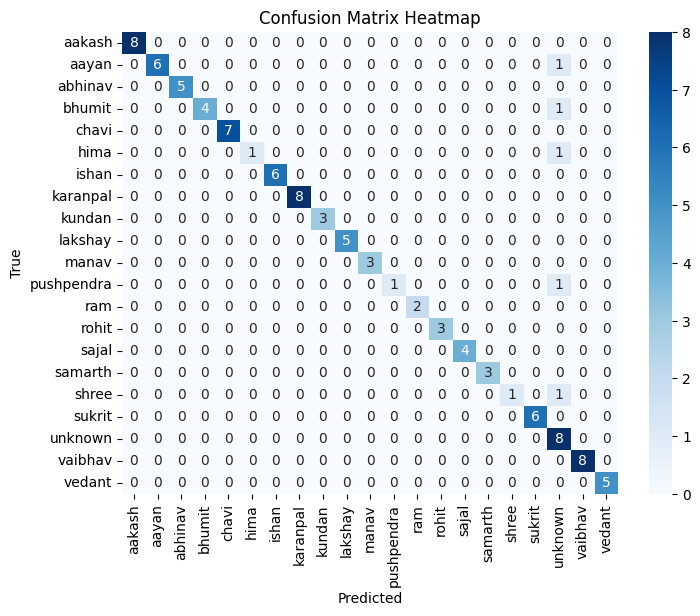

In [16]:
# heat map for the confusion matrix
# Calculate the confusion matrix
conf_matrix = confusion_matrix(names, predicted)

# Create a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['aakash', 'aayan', 'abhinav', 'bhumit', 'chavi', 'hima', 'ishan',
'karanpal','kundan', 'lakshay', 'manav', 'pushpendra', 'ram', 'rohit', 'sajal', 'samarth', 'shree', 'sukrit', 'unknown',
'vaibhav', 'vedant'], yticklabels=['aakash', 'aayan', 'abhinav', 'bhumit', 'chavi', 'hima', 'ishan',
'karanpal','kundan', 'lakshay', 'manav', 'pushpendra', 'ram', 'rohit', 'sajal', 'samarth', 'shree', 'sukrit', 'unknown',
'vaibhav', 'vedant'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix Heatmap')
plt.show()